In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cliff_jax import Cliff
from util import Buf, reduce_episodes, get_episode_reward

In [3]:
env = Cliff.full()

In [4]:
env.step(Cliff.InternalState(16, 0), 0)

(InternalState(state=Array(8, dtype=int32), step=Array(1, dtype=int32, weak_type=True)),
 Array(-1, dtype=int32, weak_type=True),
 Array(False, dtype=bool))

In [5]:
internal_state = env.reset()
env.observe(internal_state)

Array(16, dtype=int32)

In [6]:
env.step(internal_state, 1)

(InternalState(state=Array(16, dtype=int32), step=Array(1, dtype=int32, weak_type=True)),
 Array(-1, dtype=int32, weak_type=True),
 Array(False, dtype=bool))

In [7]:
import typing
import jax, jax.numpy as jnp, jax.random as jr
key = jr.key(0)

class Embedding(typing.NamedTuple):
  num_emb: int
  emb_dim: int

  def __call__(self, params, _key, x):
    return params[x]
  
  def logp(self, params, x, y):
    logits = self(params, ..., x)
    return jax.nn.log_softmax(logits)[y]

  def init(self, key):
    return jr.normal(key, (self.num_emb, self.emb_dim))

In [8]:
class EpsGreedy(typing.NamedTuple):
  model: typing.Any
  num_actions: int
  eps: float = .1

  def __call__(self, params, key, *args):
    key, eps_key = jr.split(key)
    # use cond to run the model only when it's necessary
    return jax.lax.cond(
      jr.uniform(eps_key) >= self.eps,
      # take model's prediction (greedy)
      lambda: self.model(params, key, *args).argmax(axis=-1),
      # select a random action
      lambda: jr.choice(key, self.num_actions),
    )
  
  def logp(self, params, x, y):
    return jnp.log(self.eps / self.num_actions + (1 - self.eps) * jnp.exp(self.model.logp(params, x, y)))

  def init(self, key):
    return self.model.init(key)

In [9]:
action_tab = Embedding(24, 4)
eps_greedy = EpsGreedy(action_tab, 4)

In [10]:
def run_episode(key, params, buf: Buf, buf_state: Buf.State, env: Cliff) -> Buf.State:
  "Run one episode of `env` and store the results in `buf`/`buf_state`."
  model = eps_greedy # TODO: pass this into the function

  class LoopState(typing.NamedTuple):
    key: jax.Array
    env_state: Cliff.InternalState
    buf_state: Buf.State
    done: jax.Array # bool

  def cond(state: LoopState):
    return ~state.done
  
  def body(state: LoopState):
    obs = env.observe(state.env_state)
    key, action_key = jr.split(state.key)
    action = model(params, action_key, obs)
    env_state, reward, done = env.step(state.env_state, action)
    buf_state = buf.append(state.buf_state, obs, action, reward)
    return LoopState(
      key=key,
      env_state=env_state,
      buf_state=buf_state,
      done=done,
    )

  state = LoopState(
    key=key,
    env_state=env.reset(),
    buf_state=buf_state,
    done=jnp.asarray(False),
  )
  state = jax.lax.while_loop(cond, body, state)
  buf_state = buf.end_episode(state.buf_state) # finalize episode
  return buf_state

@jax.jit
def fill_buffer(key, params, buf: Buf, buf_state: Buf.State, env: Cliff) -> Buf.State:
  "Run episodes until `buf`/`buf_state` cannot store another episode."
  class LoopState(typing.NamedTuple):
    key: jax.Array
    buf_state: Buf.State

  def cond(state: LoopState):
    return buf.can_append_episode(state.buf_state)
  
  def body(state: LoopState):
    key, run_key = jr.split(state.key)
    buf_state = run_episode(run_key, params, buf, state.buf_state, env)
    return LoopState(key, buf_state)

  state = LoopState(key, buf_state)
  state = jax.lax.while_loop(cond, body, state)
  return state.buf_state

In [11]:
@jax.jit
def expected_reward(params, buf_state: Buf.State) -> jax.Array:
  model = eps_greedy # TODO: pass this into the function

  # compute sum of logps for each episode
  def accumulate_logps(buf_state: Buf.State, ep_idx, offset, logps):
    obs, act = buf_state.observations[offset], buf_state.actions[offset]
    logp = model.logp(params, obs, act) # compute \pi(s_t\vert a_t)
    return logps.at[ep_idx].set(logps[ep_idx] + logp)
    
  weights = get_episode_reward(buf_state)
  logps = reduce_episodes(accumulate_logps, jnp.zeros_like(buf_state.ep_ends, dtype=float), buf_state)
  # weight logps and compute average to approximate E[J(\pi)] over all episodes
  return jnp.sum(weights * logps) / buf_state.num_eps

In [26]:
# initialize model parameters
key, model_key = jr.split(key)
params_init = eps_greedy.init(model_key)
params, returns, entropies = params_init, [], []

# create trajectory buffer
buf = Buf(jnp.asarray(20), jnp.asarray(env.max_steps))
buf_state = buf.empty(buf_size=100)

In [37]:
from tqdm import trange

for _ in (pbar := trange(1000)):
    # generate trajectories
    buf_state = buf_state.reset() # reset buffer instead of always reallocating
    key, ep_key = jr.split(key)
    buf_state = fill_buffer(ep_key, params, buf, buf_state, env)

    # compute gradients and update model using gradient ascent
    grads = jax.grad(expected_reward)(params, buf_state)
    params = jax.tree_util.tree_map(lambda p, g: p + 1e-3 * g, params, grads)

    # bookkeeping
    log_probs = jax.nn.log_softmax(params)
    entropy = (-jnp.mean(log_probs * jnp.exp(log_probs))).item()
    entropies.append(entropy)
    num_eps = buf_state.num_eps.item()
    # compute average return for episodes
    avg_ret = (jnp.sum(get_episode_reward(buf_state)) / buf_state.num_eps).item()
    entropies.append(entropy)
    returns.append(avg_ret)
    pbar.set_description(f"{num_eps=:4d} {avg_ret=:6.01f} {entropy=:6.03f}")

num_eps=   7 avg_ret=  38.3 entropy= 0.139: 100%|██████████| 1000/1000 [01:02<00:00, 15.89it/s]


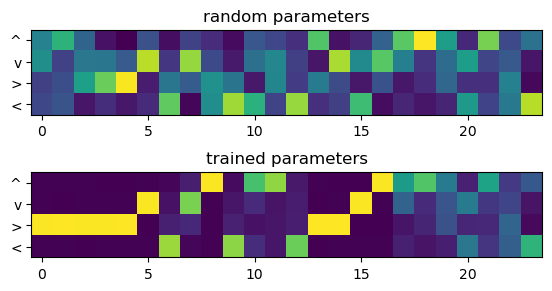

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
plt.subplot(2,1,1)
plt.title("random parameters")
plt.yticks(range(4), [*env.ACTION2CHAR.values()])
plt.imshow(jax.nn.softmax(params_init).T)
plt.subplot(2,1,2)
plt.title("trained parameters")
plt.yticks(range(4), [*env.ACTION2CHAR.values()])
plt.imshow(jax.nn.softmax(params).T)
plt.tight_layout();

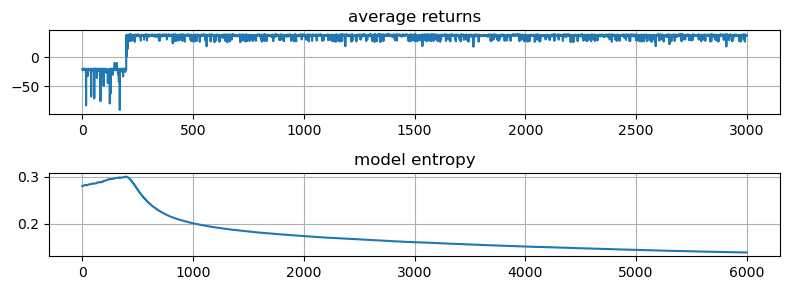

In [39]:
import pandas as pd
plt.figure(figsize=(8,3))
plt.subplot(2,1,1)
pd.Series(returns).plot.line(ax=plt.gca(), title="average returns", grid=True)
plt.subplot(2,1,2)
pd.Series(entropies).plot.line(ax=plt.gca(), title="model entropy", grid=True)
plt.tight_layout();